In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [3]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.82570,117.2264,1,9,15,39,60,70,...,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,14,22,36,41,68,80,...,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.05720,107.8740,6,9,27,57,75,110,...,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,1,5,10,18,35,59,...,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91
5,Guangdong,Mainland China,23.34170,113.4244,26,32,53,78,111,151,...,1339,1342,1345,1347,1347,1347,1348,1349,1349,1350
6,Guangxi,Mainland China,23.82980,108.7881,2,5,23,23,36,46,...,249,249,251,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,1,1,2,8,13,18,...,309,311,311,311,312,317,318,318,318,318


In [4]:
def exp(x, a, b, c):
    return a * np.exp(b * x) + c

In [5]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases

,3/2/20
Country/Region,
Mainland China,80026
South Korea,4335
Italy,2036
Iran,1501
Others,705
Japan,274
France,191
Germany,159
Spain,120


In [6]:
def plotCases(country):
    co = df[df['Country/Region'] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]

    y = np.array(co['Cases'])
    x = np.arange(y.size)

    try:
        popt, pcov = curve_fit(exp, x, y)

        residuals = y - exp(x, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)    

        if r_squared >= 0.95:
            
            plt.figure()
            plt.plot(x, y, 'ko', label="Original Data")
            plt.plot(x, exp(x, *popt), 'r-', label="Fitted Curve")
            plt.legend(title = country + ' COVID-19 Cases')
            plt.show()

            print('exponential fit: ', popt[0], 'exp(', popt[1], ' x) +', popt[2])
            print('R squared:', round(r_squared,2))
            print('Doubling time: ', round((1/popt[1])/np.log2(np.e),2), 'days')

            return (1/popt[1])/np.log2(np.e)
        
        else:
            plt.figure()
            plt.plot(x, y, 'ko', label="Original Data")
            plt.legend(title = country + ' COVID-19 Cases')
            plt.show()
            

    except:
        plt.figure()
        plt.plot(x, y, 'ko', label="Original Data")
        plt.legend(title = country + ' COVID-19 Cases')
        plt.show()
        


Mainland China


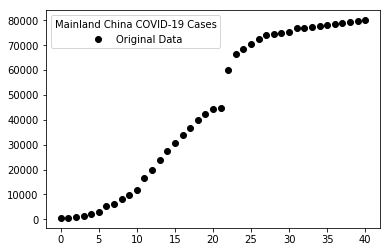



South Korea


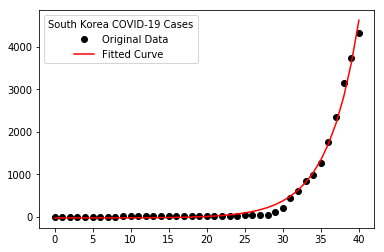

exponential fit:  0.255885895645 exp( 0.245218331965  x) + -28.53555431
R squared: 0.99
Doubling time:  2.83 days


Italy


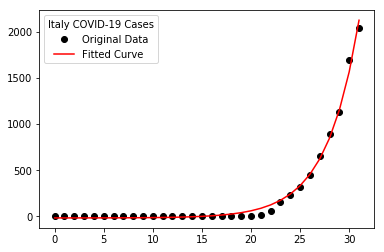

exponential fit:  0.183952794904 exp( 0.301991860046  x) + -16.0138246432
R squared: 0.99
Doubling time:  2.3 days


Iran


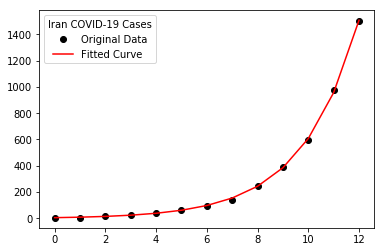

exponential fit:  6.51258156751 exp( 0.4539054155  x) + -2.6396526545
R squared: 1.0
Doubling time:  1.53 days


Others


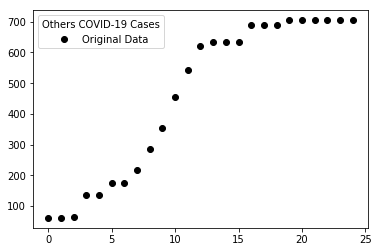



Japan


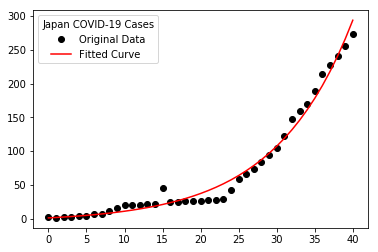

exponential fit:  5.92957429607 exp( 0.0979881536209  x) + -4.89375200702
R squared: 0.99
Doubling time:  7.07 days


France


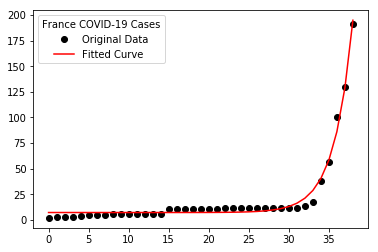

exponential fit:  1.32912682136e-05 exp( 0.433227237889  x) + 7.26825742291
R squared: 0.99
Doubling time:  1.6 days


Germany


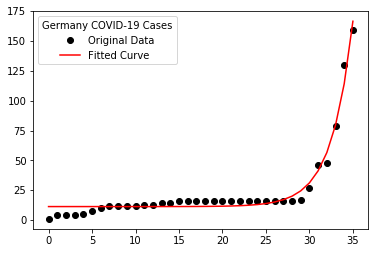

exponential fit:  8.6632849483e-05 exp( 0.411376067825  x) + 11.3333563922
R squared: 0.97
Doubling time:  1.68 days


Spain


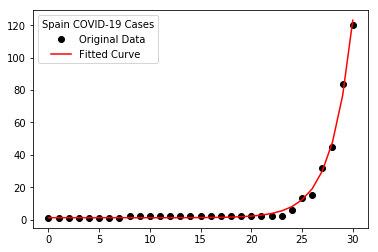

exponential fit:  6.78600224358e-05 exp( 0.480076755693  x) + 1.12716545108
R squared: 0.99
Doubling time:  1.44 days


Singapore


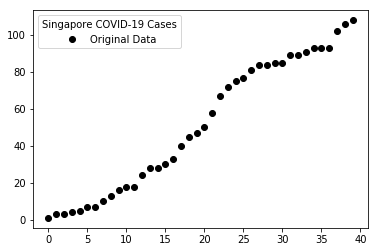



US


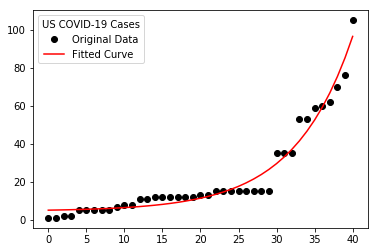

exponential fit:  0.503469168395 exp( 0.13017839203  x) + 4.57483576655
R squared: 0.96
Doubling time:  5.32 days


Hong Kong


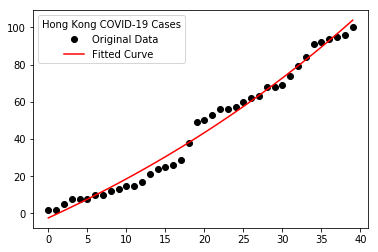

exponential fit:  114.399649318 exp( 0.0168385197258  x) + -116.782176932
R squared: 0.98
Doubling time:  41.16 days




In [7]:
topcountries = cases.index[0:20]
doublingtime = []
countries = []
print();

for c in topcountries:
    print(c)
    a = plotCases(c)
    if a:
        countries.append(c)
        doublingtime.append(a)
    print('\n')

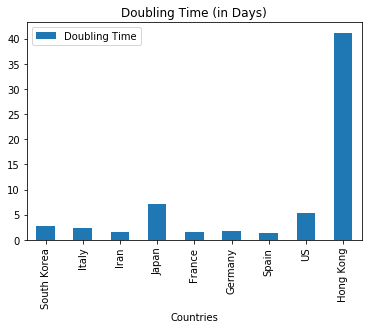

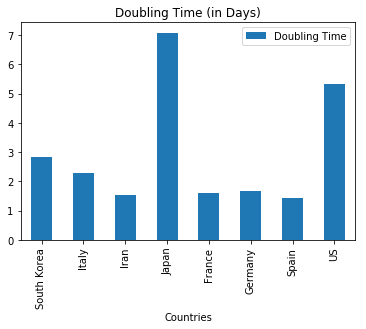

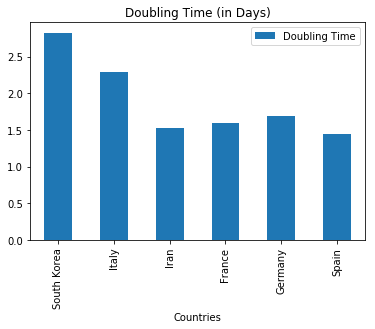

In [8]:
d = {'Countries': countries, 'Doubling Time': doublingtime}

dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', title = 'Doubling Time (in Days)');

dtf = dt[dt['Doubling Time'] < 30]
dtf.plot.bar(x = 'Countries', y = 'Doubling Time', title = 'Doubling Time (in Days)');

dtff = dt[dt['Doubling Time'] < 5]
dtff.plot.bar(x = 'Countries', y = 'Doubling Time', title = 'Doubling Time (in Days)');

plt.show()